In [4]:
import camb
pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
import matplotlib.pyplot as plt
import matplotlib
#from nbodykit.cosmology import Planck15
from astropy.cosmology import Planck15 #watch units...
import pickle
from power_spectra import *

## Setup for Sukhdeep's code

In [12]:
def get_camb(zlist,kmin=.8e-3,kmax=30,):
    #Set up a new set of parameters for CAMB
    k_smooth=1
    nk=5000
    non_linear=1

    #assuming these are right
    pars = camb.CAMBparams()
    #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
    pars.set_cosmology(H0=67.7, ombh2=0.022250, omch2=0.119800, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(ns=0.965, r=0,As =2.14e-09)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    zb=zlist
    pars.set_matter_power(redshifts=zb,kmax=kmax);
    if non_linear==1:
        pars.NonLinear = model.NonLinear_both
    else:
        pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk =results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints =nk)

    return (kh,z,pk)

In [13]:
#Set up Hankel Transform
#If you only need wgg, set j_nu=[0].
rmin=.6
rmax=110
kmax=30
kmin=.8e-3
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0],n_zeros=60000,kmin=kmin)
taper_kw=dict({'large_k_lower':10,'large_k_upper':kmax,'low_k_lower':kmin,'low_k_upper':kmin*1.2})

nr: 1047
CPU times: user 16 s, sys: 333 ms, total: 16.3 s
Wall time: 16.4 s


In [16]:
r_bins=np.logspace(np.log10(5),np.log10(110),24) 
# ^ remember we want to stop at 5 before hitting data
#^Though this doesn't account for cross-covariance between small and large scales? 
#presumably jackknife "knows" about this?

## Run it run it

In [17]:
#main
#input data
names = ['lowz','cmass','lrg','elg','qso']
propnames = ['zeff','Ng','Area']
data = np.array([[.27,.63,.8,.85,.95],[45671,74186,24404,89967,7759],[860,860,700,620,700]])
z_edges = [[0.,.5],[.35,.8],[.6,1.],[.6,1.1],[.8,1.1]] #straight from table, maybe not the most realistic
props = [dict(zip(propnames,data[:,i])) for i in range(5)]
sdict = dict(zip(names,props))
#derived quantities
#depths = np.array([Planck15.comoving_distance(z[1])-Planck15.comoving_distance(z[0]) for z in z_edges]) #nbk
depths = np.array([Planck15.comoving_distance(z[1]).value*Planck15.h #convert to Mpc/h
                   - Planck15.comoving_distance(z[0]).value*Planck15.h 
                   for z in z_edges]) 
PS = Power_Spectra(cosmo_h=0.677) #assuming Planck15's agree
bzeff = 1.75/PS.DZ_int(data[0]) #simple bias as recommended ~2
Dchi2_gg = 200 #??? #LOS integration length in the estimator.


#compute CAMB once
kh,_,pks = get_camb(data[0])

for i_s,sname in enumerate(sdict):
    #i_s,sample = 0,sdict['lowz']
    print(sname)
    sample = sdict[sname]
    print(i_s,sample)
    #compute effective volume
    area_comoving=sample['Area']*(np.pi/180)**2*(Planck15.comoving_distance(sample['zeff']).value*Planck15.h)**2
    vol=area_comoving*(depths[i_s]/2) #not sure what this factor should be but 2 is close to 500 for lowz
    n_g=sample['Ng']/vol
    g_shot_noise=1./n_g
    p_g=bzeff[i_s]**2 * pks[i_s]

    #compute wgg
    r_gg,wgg=HT.projected_correlation(k_pk=kh,pk=p_g,j_nu=0)
    wgg_re =  np.interp((r_bins[1:]+r_bins[:-1])/2,r_gg,wgg)#"binned" wgg

    #compute gg covariance
    r,cov_gggg=HT.projected_covariance(k_pk=kh,pk1=p_g+g_shot_noise,pk2=p_g+g_shot_noise,j_nu=0,taper=True,**taper_kw)
    r_re,cov_gggg_re=HT.bin_cov(r=r,cov=cov_gggg,r_bins=r_bins)
    cov_final_gg=cov_gggg_re*2./vol*Dchi2_gg #2 because there are 2 terms in the covariance, which are equal when galaxy sample is same.
    corr=HT.corr_matrix(cov=cov_final_gg)

    #compute SNR for the sample
    res = np.sqrt(wgg_re@cov_final_gg@wgg_re)
    sample['snr'] = res

Note: redshifts have been re-sorted (earliest first)
lowz
0 {'zeff': 0.27, 'Ng': 45671.0, 'Area': 860.0}
cmass
1 {'zeff': 0.63, 'Ng': 74186.0, 'Area': 860.0}
lrg
2 {'zeff': 0.8, 'Ng': 24404.0, 'Area': 700.0}
elg
3 {'zeff': 0.85, 'Ng': 89967.0, 'Area': 620.0}
qso
4 {'zeff': 0.95, 'Ng': 7759.0, 'Area': 700.0}


In [18]:
#peep results
sdict

{'lowz': {'zeff': 0.27,
  'Ng': 45671.0,
  'Area': 860.0,
  'snr': 421.43815290119954},
 'cmass': {'zeff': 0.63,
  'Ng': 74186.0,
  'Area': 860.0,
  'snr': 258.27395359199494},
 'lrg': {'zeff': 0.8, 'Ng': 24404.0, 'Area': 700.0, 'snr': 365.2130245967086},
 'elg': {'zeff': 0.85, 'Ng': 89967.0, 'Area': 620.0, 'snr': 244.485678666876},
 'qso': {'zeff': 0.95, 'Ng': 7759.0, 'Area': 700.0, 'snr': 711.4291956548494}}

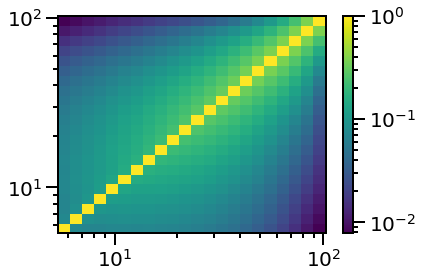

In [19]:
#look at a covariance matrix (last one) - I have only the crudest of ability to tell if right though...
plt.pcolor(r_re,r_re,corr,norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
# plt.xlim(HT.rmin,HT.rmax)
# plt.ylim(HT.rmin,HT.rmax)